# Music Recommender System

<img src="https://www.incimages.com/uploaded_files/image/1920x1080/getty_626660256_2000108620009280158_379902.jpg" width=750 height=400 />

This will detail all of the steps involved in creating this music recommender system. This code is based on the google colab notebook and educational code available at: 

https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb?utm_source=ss-recommendation-systems&utm_campaign=colab-external&utm_medium=referral&utm_content=recommendation-systems#scrollTo=StMo4lDmLqpc 


## The notebook is split into 4 sections:

1) Building rating matrix/ Calculating error

2) Training the matrix factorisation model

3) Inspecting embeddings

4) Regularisation in matrix factorisation



## Import required dependencies

In [1]:
from __future__ import print_function
import seaborn as sns
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

Instructions for updating:
non-resource variables are not supported in the long term


## 1) Preliminaries

In [2]:
artists = pd.read_csv('../Data/artists.dat', sep='	')
tags = pd.read_csv('../Data/tags.dat', sep='	', encoding='latin-1')
user_artists = pd.read_csv('../Data/user_artists.dat', sep='	')
user_friends = pd.read_csv('../Data/user_friends.dat', sep='	')
user_tagged_artists_tstamp = pd.read_csv('../Data/user_taggedartists-timestamps.dat', sep='	')
user_tagged_artists = pd.read_csv('../Data/user_taggedartists.dat', sep='	')

We create a function to be used later for splitting the data in testing and training sets

In [3]:
# Split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

### Building matrix

We design a function that maps the ```user_artists``` data to a tensorflow sparsetensor representation. Most users will not have rated each artist so this is full of 0's and hence becomes a very large matrix. This function allows us to efficiently capture this data

In [4]:
def build_rating_sparse_tensor(user_artists_df):
    indices = user_artists_df[['userID', 'artistID']].values
    values = user_artists_df['weight'].values
    return tf.SparseTensor(
        indices=indices,
        values=values,
        dense_shape=[len(user_artists['userID'].unique()), len(artists['id'].unique())])

### Calculating the error

The model approximates the ratings matrix by a low-rank product. We need a way to measure the approximation error. We'll start by using the Mean Squared Error of observed entries only. It is defined as

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$

The function below is created to calculate this

In [5]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, music_embeddings):
    predictions = tf.reduce_sum(
        tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
        tf.gather(music_embeddings, sparse_ratings.indices[:, 1]),
        axis=1)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

## 2) Training the Matrix Factorization model

### Collaborative Filtering Model (CF Model)
This class trains a matrix factorization model. Stochastic gradient descent is used in the function as the optimiser.


In [6]:
class CFModel(object):
    def __init__(self, embedding_vars, loss, metrics=None):
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None

    @property
    def embeddings(self):
        return self._embeddings

    def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
              tf.variables_initializer(opt.variables()),
              tf.local_variables_initializer())
            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()

        with self._session.as_default():
            local_init_op.run()
            iterations = []
            metrics = self._metrics or ({},)
            metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

            # Train and append results.
            for i in range(num_iterations + 1):
                _, results = self._session.run((train_op, metrics))
                if (i % 10 == 0) or i == num_iterations:
                    print("\r iteration %d: " % i + ", ".join(["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                        end='')
                    iterations.append(i)
                    for metric_val, result in zip(metrics_vals, results):
                        for k, v in result.items():
                            metric_val[k].append(v)

            for k, v in self._embedding_vars.items():
                self._embeddings[k] = v.eval()

            if plot_results:
                # Plot the metrics.
                num_subplots = len(metrics)+1
                fig = plt.figure()
                fig.set_size_inches(num_subplots*10, 8)
                for i, metric_vals in enumerate(metrics_vals):
                    ax = fig.add_subplot(1, num_subplots, i+1)
                    for k, v in metric_vals.items():
                        ax.plot(iterations, v, label=k)
                    ax.set_xlim([1, num_iterations])
                    ax.legend()
            return results

### Build the model

We build the model that uses the `sparse_mean_square_error` function. We write a function that builds a `CFModel` by creating the embedding variables and the train and test losses.

In [7]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
    
    # Split the ratings DataFrame into train and test.
    train_ratings, test_ratings = split_dataframe(ratings)
    # SparseTensor representation of the train and test datasets.
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
    # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
    embeddings = {
      "userID": U,
      "artistID": V
  }
    return CFModel(embeddings, train_loss, [metrics])

In [8]:
user_artists

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


 We convert our columns into the appropriate data type before running it through the model

### Changing user id and artist id

We get errors when using the user data as is, as the user ID values and artist ID values are not in sequential order and are often higher than the index value so we will change them so they run from 0-1891, and 0-17631 respectively.

In [9]:
user_artists.userID.unique().astype(int).max()

2100

In [10]:
user_artists.artistID.unique().astype(int).max()

18745

In [11]:
def return_inverse(x):
    p = np.zeros(x.max()+1, dtype=bool)
    p[x] = 1

    p2 = np.empty(x.max()+1, dtype=np.uint64)
    c = p.sum()
    p2[p] = np.arange(c)    
    out = p2[x]
    return out

In [12]:
inverse_user_id = return_inverse(user_artists.userID)
inverse_user_id

array([   0,    0,    0, ..., 1891, 1891, 1891], dtype=uint64)

In [13]:
inverse_artist_id = return_inverse(user_artists.artistID)
inverse_artist_id

array([   45,    46,    47, ..., 17617, 17618, 17619], dtype=uint64)

In [14]:
# Replace id columns
user_artists['userID'] = inverse_user_id
user_artists['artistID'] = inverse_artist_id

In [15]:
user_artists.describe()

,userID,artistID,weight
count,92834.000000,92834.000000,92834.00000
mean,944.222483,3235.736724,745.24393
std,546.751074,4197.216910,3751.32208
min,0.000000,0.000000,1.00000
25%,470.000000,430.000000,107.00000
50%,944.000000,1237.000000,260.00000
75%,1416.000000,4266.000000,614.00000
max,1891.000000,17631.000000,352698.00000


We can see the userID now has a max value of 1,891 and artistID has a max value of 17,631

### Normalisation

The variety in weights are very large which will cause issues with our ```CFModel``` so we normalise these values between a value of 0-1 

The code below can be uncommented to try a z score normalisation for different results

In [16]:
# copy the data
user_artists_norm = user_artists.copy()
  
# apply normalization techniques by Column weight
column = 'weight'
user_artists_norm[column] = (user_artists_norm[column] - user_artists_norm[column].min()) / (user_artists_norm[column].max() - user_artists_norm[column].min())    

# z score normalisation
#user_artists_norm[column] = (user_artists_norm[column] - user_artists_norm[column].mean()) / user_artists_norm[column].std()    
  
# view normalized data
user_artists_norm.head()

,userID,artistID,weight
0,0,45,0.039360
1,0,46,0.033142
2,0,47,0.032181
3,0,48,0.029201
4,0,49,0.025467


### Build the CF Model and train it

2021-12-02 09:25:17.668856: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 iteration 20: train_error=1.287163, test_error=1.459350

 iteration 50: train_error=0.843567, test_error=1.164468

 iteration 80: train_error=0.604698, test_error=0.999911

 iteration 110: train_error=0.456866, test_error=0.893065

 iteration 140: train_error=0.357864, test_error=0.817484

 iteration 170: train_error=0.287990, test_error=0.760956

 iteration 200: train_error=0.236745, test_error=0.716973

 iteration 230: train_error=0.198024, test_error=0.681718

 iteration 260: train_error=0.168053, test_error=0.652794

 iteration 290: train_error=0.144383, test_error=0.628615

 iteration 320: train_error=0.125367, test_error=0.608086

 iteration 350: train_error=0.109863, test_error=0.590428

 iteration 380: train_error=0.097057, test_error=0.575071

 iteration 410: train_error=0.086358, test_error=0.561586

 iteration 440: train_error=0.077330, test_error=0.549647

 iteration 470: train_error=0.069640, test_error=0.538998

 iteration 500: train_error=0.063038, test_error=0.529439

 iteration 530: train_error=0.057326, test_error=0.520808

 iteration 560: train_error=0.052353, test_error=0.512976

 iteration 590: train_error=0.047995, test_error=0.505836

 iteration 620: train_error=0.044154, test_error=0.499298

 iteration 650: train_error=0.040753, test_error=0.493289

 iteration 680: train_error=0.037727, test_error=0.487748

 iteration 710: train_error=0.035021, test_error=0.482621

 iteration 740: train_error=0.032593, test_error=0.477863

 iteration 770: train_error=0.030406, test_error=0.473436

 iteration 790: train_error=0.029067, test_error=0.470652

 iteration 810: train_error=0.027812, test_error=0.467992

 iteration 830: train_error=0.026636, test_error=0.465446

 iteration 850: train_error=0.025532, test_error=0.463009

 iteration 870: train_error=0.024493, test_error=0.460673

 iteration 890: train_error=0.023516, test_error=0.458432

 iteration 910: train_error=0.022595, test_error=0.456281

 iteration 940: train_error=0.021310, test_error=0.453211

 iteration 960: train_error=0.020512, test_error=0.451261

 iteration 990: train_error=0.019395, test_error=0.448472

 iteration 1000: train_error=0.019043, test_error=0.447577

[{'train_error': 0.01904296, 'test_error': 0.44757697}]

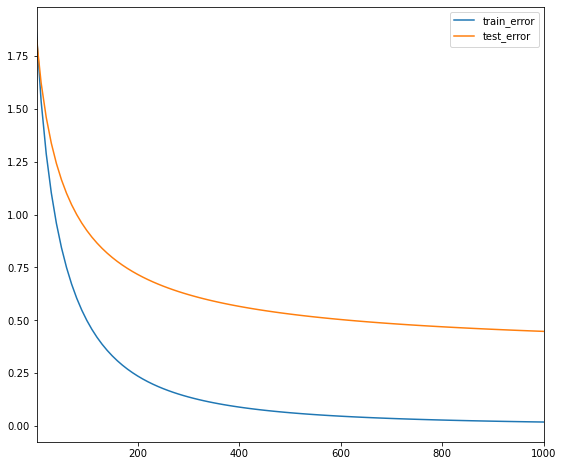

In [17]:
model = build_model(user_artists_norm, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10)

## 3) Inspecting the Embeddings

We look at the recommendations of the system using the dot product and cosine similarity which are two different similarity measures. We create a nearest neighbours function to recommend similar artists.

In [18]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):

    u = query_embedding
    V = item_embeddings
    if measure == COSINE:
        V = V / np.linalg.norm(V, axis=1, keepdims=True)
        u = u / np.linalg.norm(u)
    scores = u.dot(V.T)
    return scores

In [19]:
def artist_neighbors(model, title_substring, measure=DOT, k=6):
  ids =  artists[artists['name'].str.contains(title_substring)].index.values
  titles = artists.iloc[ids]['name'].values
  if len(titles) == 0:
    raise ValueError("Found no artists with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching artist. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  artistID = ids[0]
  scores = compute_scores(
      model.embeddings["artistID"][artistID], model.embeddings["artistID"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'names': artists['name']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

### Testing

We input an artist to see what recommendations our system returns to us

In [20]:
artist_neighbors(model, "Johnny Cash", DOT)
artist_neighbors(model, "Johnny Cash", COSINE)

Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,dot score,names
5638,3.441453,Boy Talks Trash
17278,3.338759,Lava
712,3.249975,Johnny Cash
9645,3.093319,Die Fantastischen Vier
2129,3.087614,Георг Корг
6110,3.066176,Negative


Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,cosine score,names
712,1.000000,Johnny Cash
17278,0.640777,Lava
17086,0.636165,The Post-Modern Cliche
5638,0.619617,Boy Talks Trash
13065,0.603140,Konami
4114,0.594109,The Suicide Machines


These results are interesting but it seems our system could be improved upon.

### Model initialisation

It seems the initialisation parameters may play a factor in the results of our system as artists with few ratings may have had their embeddings initialised with a high norm. We use regularisation to combat this by adjusting the value of ```init_stdev``` (previously at 0.5 now changed to 0.05)

 iteration 20: train_error=0.000299, test_error=0.000366

 iteration 50: train_error=0.000297, test_error=0.000365

 iteration 80: train_error=0.000296, test_error=0.000364

 iteration 110: train_error=0.000294, test_error=0.000363

 iteration 140: train_error=0.000293, test_error=0.000363

 iteration 170: train_error=0.000291, test_error=0.000362

 iteration 200: train_error=0.000290, test_error=0.000361

 iteration 230: train_error=0.000288, test_error=0.000360

 iteration 260: train_error=0.000287, test_error=0.000360

 iteration 290: train_error=0.000286, test_error=0.000359

 iteration 320: train_error=0.000284, test_error=0.000358

 iteration 350: train_error=0.000283, test_error=0.000357

 iteration 380: train_error=0.000282, test_error=0.000357

 iteration 410: train_error=0.000280, test_error=0.000356

 iteration 430: train_error=0.000280, test_error=0.000356

 iteration 450: train_error=0.000279, test_error=0.000355

 iteration 470: train_error=0.000278, test_error=0.000355

 iteration 500: train_error=0.000277, test_error=0.000354

 iteration 530: train_error=0.000275, test_error=0.000353

 iteration 560: train_error=0.000274, test_error=0.000353

 iteration 590: train_error=0.000273, test_error=0.000352

 iteration 610: train_error=0.000272, test_error=0.000352

 iteration 630: train_error=0.000271, test_error=0.000351

 iteration 650: train_error=0.000271, test_error=0.000351

 iteration 670: train_error=0.000270, test_error=0.000350

 iteration 690: train_error=0.000269, test_error=0.000350

 iteration 710: train_error=0.000268, test_error=0.000350

 iteration 730: train_error=0.000268, test_error=0.000349

 iteration 760: train_error=0.000266, test_error=0.000349

 iteration 790: train_error=0.000265, test_error=0.000348

 iteration 820: train_error=0.000264, test_error=0.000347

 iteration 840: train_error=0.000263, test_error=0.000347

 iteration 870: train_error=0.000262, test_error=0.000346

 iteration 890: train_error=0.000262, test_error=0.000346

 iteration 920: train_error=0.000261, test_error=0.000346

 iteration 950: train_error=0.000260, test_error=0.000345

 iteration 980: train_error=0.000259, test_error=0.000344

 iteration 1000: train_error=0.000258, test_error=0.000344Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,dot score,names
712,0.055784,Johnny Cash
16968,0.051251,Riceboy Sleeps
13790,0.042951,Antonello Venditti
3021,0.042440,Polar Bear Club
10392,0.040910,Colette Carr
6218,0.039689,TV-2


Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,cosine score,names
712,1.000000,Johnny Cash
6218,0.598475,TV-2
3021,0.596209,Polar Bear Club
4737,0.592499,Face to Face
16230,0.575613,The Recoys
10392,0.570717,Colette Carr


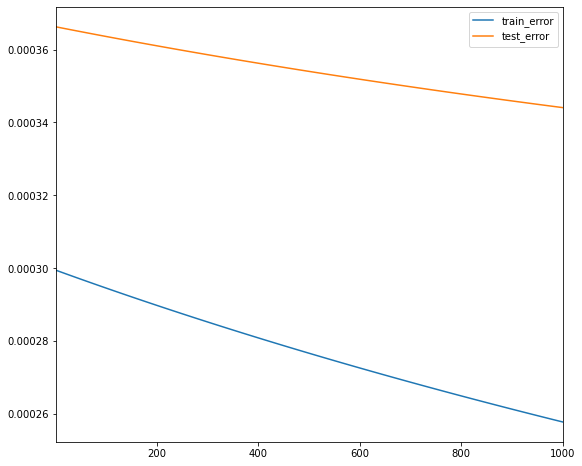

In [21]:
# Solution
model_lowinit = build_model(user_artists_norm, embedding_dim=30, init_stddev=0.05)
model_lowinit.train(num_iterations=1000, learning_rate=10.)
artist_neighbors(model_lowinit, "Johnny Cash", DOT)
artist_neighbors(model_lowinit, "Johnny Cash", COSINE)
#movie_embedding_norm([model, model_lowinit])

## 4) Regularization In Matrix Factorization

In the code above, loss was defined as the mean squared error on the observed part of the rating matrix.  This can often cause issues when the model does not learn how to place the embeddings of irrelevant artists. This is called *folding*.

We add some regularization terms to deal with this problem:
- Regularization of the model parameters. This is a common regularization term on the embedding matrices, given by 
$$
r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2
$$
- A global prior that pushes the prediction of any pair towards zero, called the *gravity* term. This is given by 
$$
g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2
$$

Total loss can now be calculated as:
$$
\frac{1}{|\Omega|}\sum_{(i, j) \in \Omega} (A_{ij} - \langle U_i, V_j\rangle)^2 + \lambda _r r(U, V) + \lambda_g g(U, V)
$$

In [22]:

def gravity(U, V):
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"userId": U, "artistID": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

We build the regularised model and observe the results

 iteration 10: train_error_observed=0.000331, test_error_observed=0.000253, observed_loss=0.000331, regularization_loss=0.017056, gravity_loss=0.000208

 iteration 30: train_error_observed=0.000310, test_error_observed=0.000233, observed_loss=0.000310, regularization_loss=0.016265, gravity_loss=0.000188

 iteration 50: train_error_observed=0.000291, test_error_observed=0.000216, observed_loss=0.000291, regularization_loss=0.015536, gravity_loss=0.000171

 iteration 70: train_error_observed=0.000274, test_error_observed=0.000200, observed_loss=0.000274, regularization_loss=0.014864, gravity_loss=0.000155

 iteration 90: train_error_observed=0.000259, test_error_observed=0.000186, observed_loss=0.000259, regularization_loss=0.014243, gravity_loss=0.000140

 iteration 110: train_error_observed=0.000246, test_error_observed=0.000173, observed_loss=0.000246, regularization_loss=0.013669, gravity_loss=0.000127

 iteration 130: train_error_observed=0.000234, test_error_observed=0.000162, observed_loss=0.000234, regularization_loss=0.013138, gravity_loss=0.000115

 iteration 150: train_error_observed=0.000223, test_error_observed=0.000151, observed_loss=0.000223, regularization_loss=0.012647, gravity_loss=0.000105

 iteration 170: train_error_observed=0.000213, test_error_observed=0.000142, observed_loss=0.000213, regularization_loss=0.012192, gravity_loss=0.000095

 iteration 190: train_error_observed=0.000204, test_error_observed=0.000133, observed_loss=0.000204, regularization_loss=0.011771, gravity_loss=0.000086

 iteration 210: train_error_observed=0.000196, test_error_observed=0.000126, observed_loss=0.000196, regularization_loss=0.011379, gravity_loss=0.000078

 iteration 230: train_error_observed=0.000189, test_error_observed=0.000119, observed_loss=0.000189, regularization_loss=0.011016, gravity_loss=0.000071

 iteration 250: train_error_observed=0.000182, test_error_observed=0.000112, observed_loss=0.000182, regularization_loss=0.010678, gravity_loss=0.000064

 iteration 270: train_error_observed=0.000176, test_error_observed=0.000107, observed_loss=0.000176, regularization_loss=0.010363, gravity_loss=0.000058

 iteration 290: train_error_observed=0.000171, test_error_observed=0.000102, observed_loss=0.000171, regularization_loss=0.010070, gravity_loss=0.000053

 iteration 310: train_error_observed=0.000166, test_error_observed=0.000097, observed_loss=0.000166, regularization_loss=0.009796, gravity_loss=0.000048

 iteration 330: train_error_observed=0.000162, test_error_observed=0.000093, observed_loss=0.000162, regularization_loss=0.009540, gravity_loss=0.000043

 iteration 350: train_error_observed=0.000158, test_error_observed=0.000089, observed_loss=0.000158, regularization_loss=0.009301, gravity_loss=0.000039

 iteration 370: train_error_observed=0.000155, test_error_observed=0.000085, observed_loss=0.000155, regularization_loss=0.009077, gravity_loss=0.000036

 iteration 390: train_error_observed=0.000151, test_error_observed=0.000082, observed_loss=0.000151, regularization_loss=0.008867, gravity_loss=0.000032

 iteration 410: train_error_observed=0.000149, test_error_observed=0.000079, observed_loss=0.000149, regularization_loss=0.008669, gravity_loss=0.000029

 iteration 430: train_error_observed=0.000146, test_error_observed=0.000077, observed_loss=0.000146, regularization_loss=0.008484, gravity_loss=0.000027

 iteration 450: train_error_observed=0.000144, test_error_observed=0.000075, observed_loss=0.000144, regularization_loss=0.008309, gravity_loss=0.000024

 iteration 470: train_error_observed=0.000141, test_error_observed=0.000072, observed_loss=0.000141, regularization_loss=0.008144, gravity_loss=0.000022

 iteration 490: train_error_observed=0.000140, test_error_observed=0.000071, observed_loss=0.000140, regularization_loss=0.007988, gravity_loss=0.000020

 iteration 510: train_error_observed=0.000138, test_error_observed=0.000069, observed_loss=0.000138, regularization_loss=0.007840, gravity_loss=0.000018

 iteration 530: train_error_observed=0.000136, test_error_observed=0.000067, observed_loss=0.000136, regularization_loss=0.007700, gravity_loss=0.000016

 iteration 550: train_error_observed=0.000135, test_error_observed=0.000066, observed_loss=0.000135, regularization_loss=0.007568, gravity_loss=0.000015

 iteration 570: train_error_observed=0.000134, test_error_observed=0.000065, observed_loss=0.000134, regularization_loss=0.007442, gravity_loss=0.000014

 iteration 590: train_error_observed=0.000132, test_error_observed=0.000063, observed_loss=0.000132, regularization_loss=0.007321, gravity_loss=0.000012

 iteration 610: train_error_observed=0.000131, test_error_observed=0.000062, observed_loss=0.000131, regularization_loss=0.007207, gravity_loss=0.000011

 iteration 630: train_error_observed=0.000130, test_error_observed=0.000061, observed_loss=0.000130, regularization_loss=0.007097, gravity_loss=0.000010

 iteration 650: train_error_observed=0.000130, test_error_observed=0.000061, observed_loss=0.000130, regularization_loss=0.006992, gravity_loss=0.000009

 iteration 670: train_error_observed=0.000129, test_error_observed=0.000060, observed_loss=0.000129, regularization_loss=0.006892, gravity_loss=0.000008

 iteration 690: train_error_observed=0.000128, test_error_observed=0.000059, observed_loss=0.000128, regularization_loss=0.006796, gravity_loss=0.000008

 iteration 710: train_error_observed=0.000128, test_error_observed=0.000058, observed_loss=0.000128, regularization_loss=0.006703, gravity_loss=0.000007

 iteration 730: train_error_observed=0.000127, test_error_observed=0.000058, observed_loss=0.000127, regularization_loss=0.006614, gravity_loss=0.000006

 iteration 750: train_error_observed=0.000126, test_error_observed=0.000057, observed_loss=0.000126, regularization_loss=0.006528, gravity_loss=0.000006

 iteration 770: train_error_observed=0.000126, test_error_observed=0.000057, observed_loss=0.000126, regularization_loss=0.006445, gravity_loss=0.000005

 iteration 790: train_error_observed=0.000126, test_error_observed=0.000056, observed_loss=0.000126, regularization_loss=0.006365, gravity_loss=0.000005

 iteration 810: train_error_observed=0.000125, test_error_observed=0.000056, observed_loss=0.000125, regularization_loss=0.006287, gravity_loss=0.000004

 iteration 830: train_error_observed=0.000125, test_error_observed=0.000056, observed_loss=0.000125, regularization_loss=0.006212, gravity_loss=0.000004

 iteration 850: train_error_observed=0.000125, test_error_observed=0.000055, observed_loss=0.000125, regularization_loss=0.006139, gravity_loss=0.000004

 iteration 870: train_error_observed=0.000124, test_error_observed=0.000055, observed_loss=0.000124, regularization_loss=0.006068, gravity_loss=0.000003

 iteration 890: train_error_observed=0.000124, test_error_observed=0.000055, observed_loss=0.000124, regularization_loss=0.005999, gravity_loss=0.000003

 iteration 910: train_error_observed=0.000124, test_error_observed=0.000054, observed_loss=0.000124, regularization_loss=0.005932, gravity_loss=0.000003

 iteration 930: train_error_observed=0.000124, test_error_observed=0.000054, observed_loss=0.000124, regularization_loss=0.005867, gravity_loss=0.000002

 iteration 950: train_error_observed=0.000123, test_error_observed=0.000054, observed_loss=0.000123, regularization_loss=0.005803, gravity_loss=0.000002

 iteration 970: train_error_observed=0.000123, test_error_observed=0.000054, observed_loss=0.000123, regularization_loss=0.005741, gravity_loss=0.000002

 iteration 990: train_error_observed=0.000123, test_error_observed=0.000054, observed_loss=0.000123, regularization_loss=0.005680, gravity_loss=0.000002

 iteration 1010: train_error_observed=0.000123, test_error_observed=0.000054, observed_loss=0.000123, regularization_loss=0.005620, gravity_loss=0.000002

 iteration 1030: train_error_observed=0.000123, test_error_observed=0.000053, observed_loss=0.000123, regularization_loss=0.005561, gravity_loss=0.000001

 iteration 1050: train_error_observed=0.000123, test_error_observed=0.000053, observed_loss=0.000123, regularization_loss=0.005504, gravity_loss=0.000001

 iteration 1070: train_error_observed=0.000123, test_error_observed=0.000053, observed_loss=0.000123, regularization_loss=0.005448, gravity_loss=0.000001

 iteration 1090: train_error_observed=0.000123, test_error_observed=0.000053, observed_loss=0.000123, regularization_loss=0.005393, gravity_loss=0.000001

 iteration 1110: train_error_observed=0.000123, test_error_observed=0.000053, observed_loss=0.000123, regularization_loss=0.005339, gravity_loss=0.000001

 iteration 1130: train_error_observed=0.000122, test_error_observed=0.000053, observed_loss=0.000122, regularization_loss=0.005286, gravity_loss=0.000001

 iteration 1150: train_error_observed=0.000122, test_error_observed=0.000053, observed_loss=0.000122, regularization_loss=0.005233, gravity_loss=0.000001

 iteration 1170: train_error_observed=0.000122, test_error_observed=0.000053, observed_loss=0.000122, regularization_loss=0.005182, gravity_loss=0.000001

 iteration 1190: train_error_observed=0.000122, test_error_observed=0.000053, observed_loss=0.000122, regularization_loss=0.005131, gravity_loss=0.000001

 iteration 1210: train_error_observed=0.000122, test_error_observed=0.000053, observed_loss=0.000122, regularization_loss=0.005082, gravity_loss=0.000001

 iteration 1230: train_error_observed=0.000122, test_error_observed=0.000053, observed_loss=0.000122, regularization_loss=0.005033, gravity_loss=0.000001

 iteration 1250: train_error_observed=0.000122, test_error_observed=0.000053, observed_loss=0.000122, regularization_loss=0.004984, gravity_loss=0.000001

 iteration 1270: train_error_observed=0.000122, test_error_observed=0.000053, observed_loss=0.000122, regularization_loss=0.004936, gravity_loss=0.000000

 iteration 1290: train_error_observed=0.000122, test_error_observed=0.000053, observed_loss=0.000122, regularization_loss=0.004889, gravity_loss=0.000000

 iteration 1310: train_error_observed=0.000122, test_error_observed=0.000053, observed_loss=0.000122, regularization_loss=0.004843, gravity_loss=0.000000

 iteration 1330: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004797, gravity_loss=0.000000

 iteration 1350: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004752, gravity_loss=0.000000

 iteration 1370: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004707, gravity_loss=0.000000

 iteration 1390: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004663, gravity_loss=0.000000

 iteration 1410: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004620, gravity_loss=0.000000

 iteration 1430: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004577, gravity_loss=0.000000

 iteration 1450: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004534, gravity_loss=0.000000

 iteration 1470: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004492, gravity_loss=0.000000

 iteration 1490: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004450, gravity_loss=0.000000

 iteration 1510: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004409, gravity_loss=0.000000

 iteration 1530: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004369, gravity_loss=0.000000

 iteration 1550: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004328, gravity_loss=0.000000

 iteration 1570: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004288, gravity_loss=0.000000

 iteration 1590: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004249, gravity_loss=0.000000

 iteration 1610: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004210, gravity_loss=0.000000

 iteration 1630: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004171, gravity_loss=0.000000

 iteration 1650: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004133, gravity_loss=0.000000

 iteration 1670: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004096, gravity_loss=0.000000

 iteration 1690: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004058, gravity_loss=0.000000

 iteration 1710: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.004021, gravity_loss=0.000000

 iteration 1730: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.003984, gravity_loss=0.000000

 iteration 1750: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.003948, gravity_loss=0.000000

 iteration 1770: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.003912, gravity_loss=0.000000

 iteration 1790: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.003876, gravity_loss=0.000000

 iteration 1810: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.003841, gravity_loss=0.000000

 iteration 1830: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.003806, gravity_loss=0.000000

 iteration 1850: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.003772, gravity_loss=0.000000

 iteration 1870: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.003737, gravity_loss=0.000000

 iteration 1890: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.003704, gravity_loss=0.000000

 iteration 1910: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.003670, gravity_loss=0.000000

 iteration 1930: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.003637, gravity_loss=0.000000

 iteration 1950: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.003604, gravity_loss=0.000000

 iteration 1970: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.003571, gravity_loss=0.000000

 iteration 1990: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.003539, gravity_loss=0.000000

 iteration 2000: train_error_observed=0.000122, test_error_observed=0.000052, observed_loss=0.000122, regularization_loss=0.003523, gravity_loss=0.000000

[{'train_error_observed': 0.00012242547, 'test_error_observed': 5.2216194e-05},
 {'observed_loss': 0.00012242547,
  'regularization_loss': 0.0035225393,
  'gravity_loss': 2.7017721e-08}]

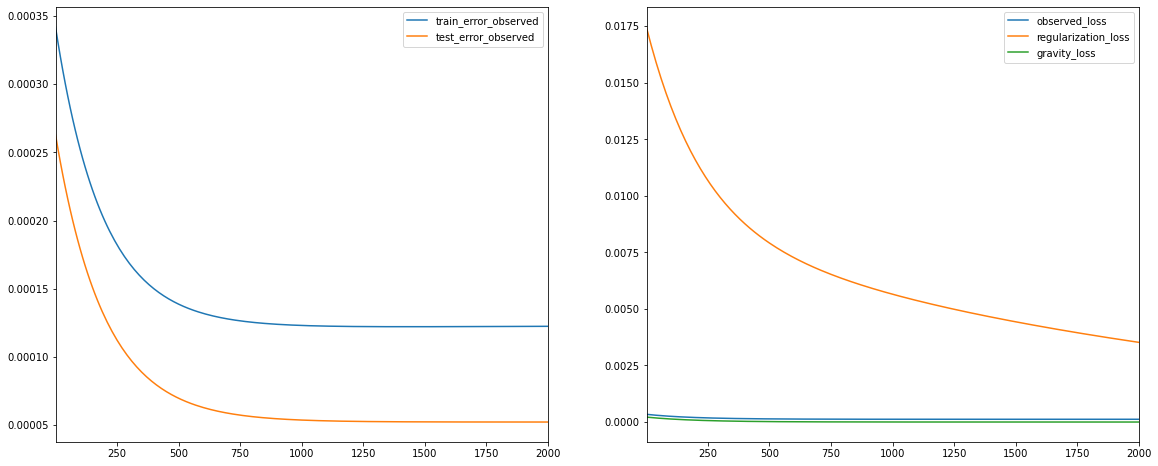

In [23]:
reg_model = build_regularized_model(
    user_artists_norm, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

### Testing

In [24]:
artist_neighbors(model_lowinit, "Johnny Cash", DOT)
artist_neighbors(model_lowinit, "Johnny Cash", COSINE)

Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,dot score,names
712,0.055784,Johnny Cash
16968,0.051251,Riceboy Sleeps
13790,0.042951,Antonello Venditti
3021,0.042440,Polar Bear Club
10392,0.040910,Colette Carr
6218,0.039689,TV-2


Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,cosine score,names
712,1.000000,Johnny Cash
6218,0.598475,TV-2
3021,0.596209,Polar Bear Club
4737,0.592499,Face to Face
16230,0.575613,The Recoys
10392,0.570717,Colette Carr


## Results

Our recommender system is fully functional and outputs artists based on similarity metrics to whatever artist the user enters. The system appears to have some issues as there are often useful recommendations alongside other, not so useful recommendations. The inner workings of the systems need some work before this would be deemed acceptable however as a starting point it is a useful recommender system to be further fine tuned.

# Novel Lyrics Display

This section details the novel lyrics aspect of this system. A user can input a favourite artist and song and will be returned some classic lyrics from that artist on screen.

In [25]:
pip install lyricsgenius

Note: you may need to restart the kernel to use updated packages.


In [26]:
import os
import json
import time

Token has been removed below after successfully running the API call

In [27]:
token = 'xxxxxxxxxxxxxxxxxxxxxxxxxxx'

In [28]:
import lyricsgenius as lg
genius = lg.Genius(token)

In [29]:
song_title = "Walk the line"
artist_name = "Johnny Cash"

In [30]:
song = genius.search_song(title=song_title, artist=artist_name)

Searching for "Walk the line" by Johnny Cash...


Done.


In [31]:
lyrics = song.lyrics

In [32]:
l=lyrics.split('\n')

In [33]:
for line in l:
    print(line)
    
    # uncomment for interactive notebook running
    #time.sleep(2)

[Verse 1]
I keep a close watch on this heart of mine
I keep my eyes wide open all the time
I keep the ends out for the tie that binds
Because you're mine, I walk the line

[Verse 2]
I find it very, very easy to be true
I find myself alone when each day is through
Yes, I'll admit that I'm a fool for you
Because you're mine, I walk the line

[Verse 3]
As sure as night is dark and day is light
I keep you on my mind both day and night
And happiness I've known proves that it's right
Because you're mine, I walk the line

[Verse 4]
You've got a way to keep me on your side
You give me cause for love that I can't hide
For you, I know I'd even try to turn the tide
Because you're mine, I walk the line

[Verse 1]
I keep a close watch on this heart of mine
I keep my eyes wide open all the time
I keep the ends out for the tie that binds
Because you're mine, I walk the line22EmbedShare URLCopyEmbedCopy


<img src="https://www.billboard.com/wp-content/uploads/media/johnny-cash-bw-portrait-klm-billboard-1548.jpg" width=750 height=400 />